In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import time
start_time = time.time()
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


## Install Libraries

In [2]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16511 sha256=4c867d9af16fb4ae1d172f913b78a4c3ca7b8897a5bbee671a5e213323b2eac3
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


## Import Libraries


In [3]:
import matplotlib. pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import transformers as ppb
import swifter
from tqdm.auto import tqdm
tqdm.pandas()
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer




# Introduction
### We have three main data files at our disposal:

### train_essays.csv: The training set with essays written by students and a few examples of LLM-generated essays.
### test_essays.csv: The test set with essays for which we need to predict whether they were generated by an LLM.
### train_prompts.csv: The prompts used to generate the essays, containing both the instructions and source texts.
### Our first step is to load these files and get an intuitive feel for their content.



In [4]:
train_essays = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train_essays = train_essays.dropna(how='all')

In [5]:
test_df = pd.read_csv(f'/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')  # Read CSV file into a DataFrame
test_df

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [6]:
sample_submission = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_submission

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [7]:
train_essays.head(5)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [8]:
train_essays['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

The train_essays_df DataFrame reveals a highly imbalanced distribution with 1,375 student-written essays (label '0') and only 3 LLM-generated essays (label '1').

In [9]:
train_essays[train_essays['generated']==1].head(5)

,id,prompt_id,text,generated
704,82131f68,1,"This essay will analyze, discuss and prove one...",1
740,86fe4f18,1,I strongly believe that the Electoral College ...,1
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


In [10]:
train_essays[train_essays['generated']==0].head(5)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [11]:
train_essays[(train_essays['prompt_id']==0) & (train_essays["generated"]==1)]

,id,prompt_id,text,generated
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1


## Preprocessing



WordCloud for Label '0'

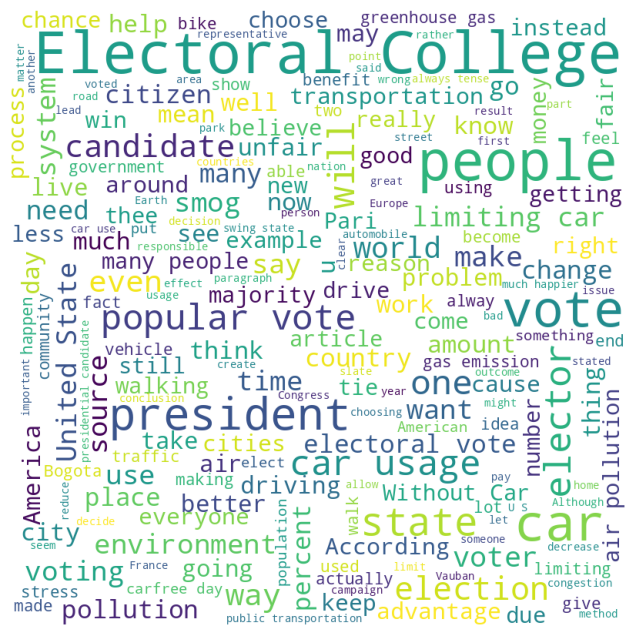

In [12]:
wc = WordCloud(width = 800,height=800,background_color='white',min_font_size=10)
wc.generate(''.join(train_essays[train_essays["generated"]==0]['text']))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

WordCloud for label '1'

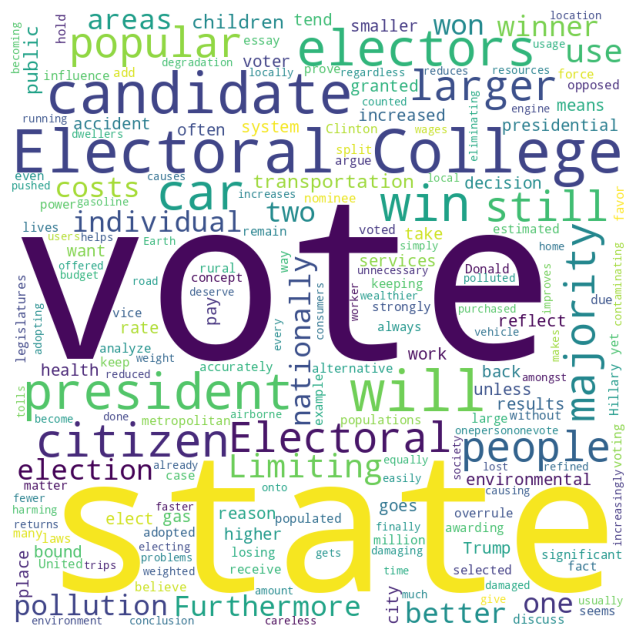

In [13]:
wc = WordCloud(width = 800,height=800,background_color='white',min_font_size=10)
wc.generate(''.join(train_essays[train_essays["generated"]==1]['text']))
plt.figure(figsize=(8,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

# Modeling

In [14]:
df = train_essays[['text','generated']]
print(df.head(2))
X = df['text']
Y = df['generated']
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3)

                                                text  generated
0  Cars. Cars have been around since they became ...          0
1  Transportation is a large necessity in most co...          0


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
tokenizer = Tokenizer(oov_token='<00V>')
tokenizer.fit_on_texts(x_train)
vocab_len = len(tokenizer.index_word)


In [17]:
train_sequences = tokenizer.texts_to_sequences(x_train)


### Padding

In [18]:
doc_length = []
for doc in train_sequences:
    doc_length.append(len(doc))
    
max(doc_length)

1364

In [19]:
max_len = np.quantile(doc_length,0.95)
max_len = int(max_len)

print(f"95% of text has {max_len} length")

95% of text has 848 length


In [20]:
train_padded = pad_sequences(train_sequences,maxlen = int(max_len))
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences,maxlen = max_len)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,Flatten

In [22]:
model = Sequential()
model.add(Embedding(vocab_len+1,10,input_length= max_len,mask_zero=True))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 848, 10)           139710    
                                                                 
 flatten (Flatten)           (None, 8480)              0         
                                                                 
 dense (Dense)               (None, 16)                135696    
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 275,551
Trainable params: 275,551
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics=['accuracy'])

In [25]:
model.fit(train_padded,y_train,validation_data = (test_padded,y_test),epochs=20,batch_size = 10,verbose=False)

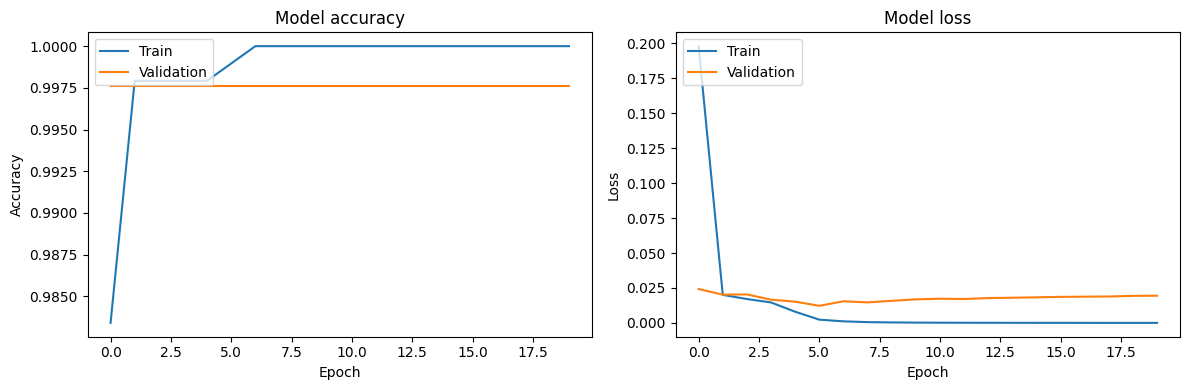

In [26]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Prediction


In [27]:
text_sequences = tokenizer.texts_to_sequences(test_df['text'])
X_test= pad_sequences(text_sequences, maxlen=max_len)


In [28]:
# Initialize an array to store predictions for each fold
fold_preds = np.zeros(shape=(len(test_df),), dtype='float32')

y = model.predict(X_test)
fold_preds += y.squeeze()


1/1 [==============================] - 0s 111ms/step


### Submission

In [29]:
submission_df = test_df[["id"]].copy()

# Add the formatted predictions to the submission DataFrame
submission_df["generated"] = fold_preds.squeeze()

In [30]:
submission_df

,id,generated
0,0000aaaa,0.003574
1,1111bbbb,0.003574
2,2222cccc,0.003574


In [31]:
submission_df.to_csv('submission.csv',index=False)